# Course 4 - Project - Part 5: Logistic regression baseline

<a name="top-5"></a>
This notebook is concerned with *Part 5: Logistic regression baseline*.

**Contents:**
* [Step 0: Loading data](#step-5.0)
* [Step 1: Evaluate the logistic regression baseline](#step-5.1)
* [Step 2: Tune its regularization strength parameter](#step-5.2)
* [Step 3: Pick a few images and compute the probability for each class](#step-5.3)
* [Step 4: Vary the regularization strength of your estimator](#step-5.4)

## Step 0: Loading data<a name="step-5.0"></a> ([top](#top-5))
---

We begin with some imports.

In [1]:
# Standard library.
import pathlib
import typing as T

# 3rd party.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project.
import utils

We load the datasets with the extracted high-level features.

In [2]:
separator = ''.center(80, '-')

path_train = pathlib.Path.cwd() / 'data' / 'swissroads-features-train.npz'
data_train = utils.load(path_train)
print(separator)
print(f'Dataset: train\n{utils.info(data_train)}')

path_valid = pathlib.Path.cwd() / 'data' / 'swissroads-features-valid.npz'
data_valid = utils.load(path_valid)
print(separator)
print(f'Dataset: valid\n{utils.info(data_valid)}')

path_test = pathlib.Path.cwd() / 'data' / 'swissroads-features-test.npz'
data_test = utils.load(path_test)
print(separator)
print(f'Dataset: test\n{utils.info(data_test)}')

--------------------------------------------------------------------------------
Dataset: train
data: shape=(280, 224, 224, 3), dtype=float32
label_idxs: shape=(280,), dtype=int64
label_strs: shape=(6,), dtype=<U10
names: shape=(280,), dtype=<U19
features: shape=(280, 1280), dtype=float32
--------------------------------------------------------------------------------
Dataset: valid
data: shape=(139, 224, 224, 3), dtype=float32
label_idxs: shape=(139,), dtype=int64
label_strs: shape=(6,), dtype=<U10
names: shape=(139,), dtype=<U19
features: shape=(139, 1280), dtype=float32
--------------------------------------------------------------------------------
Dataset: test
data: shape=(50, 224, 224, 3), dtype=float32
label_idxs: shape=(50,), dtype=int64
label_strs: shape=(6,), dtype=<U10
names: shape=(50,), dtype=<U19
features: shape=(50, 1280), dtype=float32


In [3]:
label_strs = data_train['label_strs']  # Same for all data sets.
assert (
    np.all(data_train['label_strs'] == data_valid['label_strs']) and
    np.all(data_train['label_strs'] == data_test['label_strs'])
)

X_train = data_train['data']
y_train = data_train['label_idxs']
F_train = data_train['features']
N_train = data_train['names']

X_valid = data_valid['data']
y_valid = data_valid['label_idxs']
F_valid = data_valid['features']
N_valid = data_train['names']

X_test = data_test['data']
y_test = data_test['label_idxs']
F_test = data_test['features']
N_test = data_test['names']

We will fix the seed for the PRNG in order to make computations deterministic.

In [4]:
RANDOM_SEED = 0

## Step 1: Evaluate the logistic regression baseline<a name="step-5.1"></a> ([top](#top-5))
---

We begin with some imports.

In [5]:
# Standard library.
import warnings

# 3rd party.
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

We want to use logistic regression for a multiclass classification task.

In this part it makes sense to merge the training and the validation sets since otherwise we would not make use of the validation set.

In [6]:
X_train_large = np.concatenate([X_train, X_valid])
y_train_large = np.concatenate([y_train, y_valid])
F_train_large = np.concatenate([F_train, F_valid])
N_train_large = np.concatenate([N_train, N_valid])

We create a pipeline comprised of an optional scaler and a logistic regression classifier (to be fleshed out later).

In [7]:
# Create the estimator.
logreg_pipe = Pipeline([
    ('scaler', None),
    ('logreg', None)
])

For the baseline, we decide to try:
* Scaling: none and standard-scaler.
* Strategies: one-vs-one (OVO), one-vs-rest (OVR) and softmax.

In [8]:
MAX_ITER = 200

scalers = [None, StandardScaler()]

# Define the grid of values.
grid = [
    # OVO
    {
        'scaler': scalers,
        'logreg': [
            OneVsOneClassifier(
                LogisticRegression(random_state=RANDOM_SEED)  # Make it deterministic.
            )
        ],
        'logreg__estimator__solver': ['liblinear']
    },
    # OVR
    {
        'scaler': scalers,
        'logreg': [
            LogisticRegression(random_state=RANDOM_SEED)  # Make it deterministic.
        ],
        'logreg__solver': ['liblinear'],
        'logreg__multi_class': ['ovr']
    },
    # Softmax
    {
        'scaler': scalers,
        'logreg': [
            LogisticRegression(random_state=RANDOM_SEED)  # Make it deterministic.
        ],
        'logreg__solver': ['saga'],
        'logreg__max_iter': [MAX_ITER],
        'logreg__multi_class': ['multinomial']
    }
]

**Note:** We had to work around a few warnings:
* The default maximum number of iterations for Softmax causes a `ConvergenceWarning: The max_iter was reached which means the coef_ did not converge`. So we increased this parameter from 100 (default) to 200 and suppressed the remaining warnings.

In [9]:
gs_results = []

with warnings.catch_warnings():

    # Filter convergence warnings.
    warnings.simplefilter('ignore', ConvergenceWarning)

    for params_dict in ParameterGrid(grid):
        # Set the parameters.
        logreg_pipe.set_params(**params_dict)

        # Fit the clasifier to the data.
        logreg_pipe.fit(F_train_large, y_train_large)

        # Store the scores.
        gs_result = params_dict
        gs_result['accuracy_train'] = logreg_pipe.score(F_train_large, y_train_large)
        gs_result['accuracy_test'] = logreg_pipe.score(F_test, y_test)

        # Save result.
        gs_results.append(gs_result)

We convert the results to a data frame.

In [10]:
df_results = (pd
              .DataFrame(gs_results)
              .sort_values(by='accuracy_test', ascending=False)
             )

In [11]:
# Make it more readable.
df_report = df_results.copy()
df_report['scaler'] = df_report['scaler'].apply(
    lambda est: (str(est) if est is None else
                 type(est).__name__).lower())
df_report['strategy'] = df_report['logreg'].apply(
    lambda est: ('ovo' if isinstance(est, OneVsOneClassifier) else
                 est.get_params()['multi_class']).lower())

df_report[['scaler', 'strategy', 'accuracy_train', 'accuracy_test']]

,scaler,strategy,accuracy_train,accuracy_test
3,standardscaler,ovr,1.0,0.98
2,none,ovr,1.0,0.94
5,standardscaler,multinomial,1.0,0.94
1,standardscaler,ovo,1.0,0.92
4,none,multinomial,1.0,0.92
0,none,ovo,1.0,0.90


**Comment:** So far, using a standard scaler and a logistic regression with OVR yields the best accuracy on the test set (98 %).

## Step 2: Tune its regularization strength parameter<a name="step-5.2"></a> ([top](#top-5))
---

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

We want to tune the regularization strength of the logistic regression classifier with cross-validated grid search.

In [13]:
MAX_ITER = 200

scalers = [StandardScaler()]  # This should help the solvers.

# Using np.logspace(a, b, num=k * (b - a) + 1), where a, b are integers and k > 0 is an integer, we
# include integer exponents in the range [a, b]. 
Cs = np.logspace(-4, 4, num=3 * 8 + 1)  # C defaults to 1.0.

grid = [
    # OVO
    {
        'scaler': scalers,
        'logreg': [
            OneVsOneClassifier(
                LogisticRegression(random_state=RANDOM_SEED)  # Make it deterministic.
            )
        ],
        'logreg__estimator__C': Cs,
        'logreg__estimator__solver': ['liblinear']
    },
    # OVR
    {
        'scaler': scalers,
        'logreg': [
            LogisticRegression(random_state=RANDOM_SEED)  # Make it deterministic.
        ],
        'logreg__C': Cs,
        'logreg__solver': ['liblinear'],
        'logreg__multi_class': ['ovr']
    },
    # Softmax
    {
        'scaler': scalers,
        'logreg': [
            LogisticRegression(random_state=RANDOM_SEED)  # Make it deterministic.
        ],
        'logreg__C': Cs,
        'logreg__solver': ['saga'],
        'logreg__max_iter': [MAX_ITER],
        'logreg__multi_class': ['multinomial']
    }
]

# With 10 splits the model can be trained on 90% of the data points.
cv = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED)
logreg_gscv = GridSearchCV(logreg_pipe, grid, n_jobs=-1, iid=False, refit=False, cv=cv, return_train_score=True)

We perform the cross-validated grid search.

In [14]:
with warnings.catch_warnings():

    # Filter convergence warnings.
    warnings.simplefilter('ignore', ConvergenceWarning)

    # Fit/evaluate the estimator.
    logreg_gscv.fit(F_train_large, y_train_large);

We convert the results to a data frame.

In [15]:
df_results = (pd
    .DataFrame({
        'strategy': np.where(~logreg_gscv.cv_results_['param_logreg__multi_class'].mask,
                              logreg_gscv.cv_results_['param_logreg__multi_class'], 'ovo'),
        'C': np.where(~logreg_gscv.cv_results_['param_logreg__C'].mask,
                       logreg_gscv.cv_results_['param_logreg__C'],
                       logreg_gscv.cv_results_['param_logreg__estimator__C']),
        'mean_train': logreg_gscv.cv_results_['mean_train_score'],
        'mean_test': logreg_gscv.cv_results_['mean_test_score'],
        'std_test': logreg_gscv.cv_results_['std_test_score'],
        'params': logreg_gscv.cv_results_['params']
    })
    .sort_values(by='mean_test', ascending=False)
)

### Best results for one-vs-one, one-vs-rest and softmax

Here are the 10 best combinations for one-vs-one, one-vs-rest and softmax (according to the mean test score).

In [16]:
df_results[['strategy', 'C', 'mean_train', 'mean_test', 'std_test']].head(10)

,strategy,C,mean_train,mean_test,std_test
6,ovo,0.01,0.996817,0.928450,0.032513
24,ovo,10000,1.000000,0.926256,0.037689
23,ovo,4641.59,1.000000,0.926256,0.037689
22,ovo,2154.43,1.000000,0.926256,0.037689
21,ovo,1000,1.000000,0.926256,0.037689
7,ovo,0.0215443,1.000000,0.926177,0.031384
9,ovo,0.1,1.000000,0.926177,0.031384
15,ovo,10,1.000000,0.926116,0.033095
16,ovo,21.5443,1.000000,0.926116,0.033095
19,ovo,215.443,1.000000,0.926116,0.033095


**Comment:** The OVO strategy seems to yield the best result.

We compute the accuracy of the best model (among OVO, OVR and Softmax) on the test set.

In [17]:
with warnings.catch_warnings():

    # Filter convergence warnings.
    warnings.simplefilter('ignore', ConvergenceWarning)

    params_best = df_results.iloc[0]['params']
    logreg_pipe.set_params(**params_best)
    logreg_pipe.fit(F_train_large, y_train_large)
    accuracy_train_large = logreg_pipe.score(F_train_large, y_train_large)
    accuracy_test = logreg_pipe.score(F_test, y_test)
    print(f'training accuracy: {accuracy_train_large * 100:.1f} %')
    print(f'test accuracy: {accuracy_test * 100:.1f} %')

training accuracy: 99.5 %
test accuracy: 92.0 %


In [18]:
# Persist the result.
desc = ', '.join([f'{key}={df_results.iloc[0][key]}' for key in ['strategy', 'C']])
utils.persist_result('logistic ovo/ovr/softmax', 'part-05-a', desc, accuracy_test)

### Best results for one-vs-rest and softmax only

here are the 10 best combinations for one-vs-rest and softmax only (according to the mean test score).

In [19]:
df_results[df_results['strategy'] != 'ovo'].head(10)

,strategy,C,mean_train,mean_test,std_test,params
61,multinomial,0.464159,1.000000,0.925871,0.028801,"{'logreg': LogisticRegression(C=1.0, class_wei..."
60,multinomial,0.215443,1.000000,0.925871,0.028801,"{'logreg': LogisticRegression(C=1.0, class_wei..."
65,multinomial,10,1.000000,0.923545,0.029290,"{'logreg': LogisticRegression(C=1.0, class_wei..."
67,multinomial,46.4159,1.000000,0.923545,0.029290,"{'logreg': LogisticRegression(C=1.0, class_wei..."
70,multinomial,464.159,1.000000,0.923545,0.029290,"{'logreg': LogisticRegression(C=1.0, class_wei..."
69,multinomial,215.443,1.000000,0.923545,0.029290,"{'logreg': LogisticRegression(C=1.0, class_wei..."
68,multinomial,100,1.000000,0.923545,0.029290,"{'logreg': LogisticRegression(C=1.0, class_wei..."
63,multinomial,2.15443,1.000000,0.923545,0.029290,"{'logreg': LogisticRegression(C=1.0, class_wei..."
66,multinomial,21.5443,1.000000,0.923545,0.029290,"{'logreg': LogisticRegression(C=1.0, class_wei..."
55,multinomial,0.00464159,0.995227,0.923545,0.032776,"{'logreg': LogisticRegression(C=1.0, class_wei..."


We compute the accuracy of the best model (among OVR and Softmax) on the test set.

In [20]:
with warnings.catch_warnings():

    # Filter convergence warnings.
    warnings.simplefilter('ignore', ConvergenceWarning)

    df_results_not_ovo = df_results[df_results['strategy'] != 'ovo']
    params_best = df_results_not_ovo.iloc[0]['params']
    logreg_pipe.set_params(**params_best)
    logreg_pipe.fit(F_train_large, y_train_large)
    accuracy_train_large = logreg_pipe.score(F_train_large, y_train_large)
    accuracy_test = logreg_pipe.score(F_test, y_test)
    print(f'training accuracy: {accuracy_train_large * 100:.1f} %')
    print(f'test accuracy: {accuracy_test * 100:.1f} %')

training accuracy: 100.0 %
test accuracy: 94.0 %


In [21]:
# Persist the result.
desc = ', '.join([f'{key}={df_results_not_ovo.iloc[0][key]}' for key in ['strategy', 'C']])
utils.persist_result('logistic ovr/softmax', 'part-05-b', desc, accuracy_test)

## Step 3: Pick a few images and compute the probability for each class<a name="step-5.3"></a> ([top](#top-5))
--- 

**Note:** Since only one-vs-rest and softmax offer probability estimates, we put one-vs-one aside.

We start by randomly picking 2 images in each class.

In [22]:
NSAMPLES = 2

# Make it deterministic.
np.random.seed(RANDOM_SEED)

buf = []
for label in range(len(label_strs)):
    # Randomly choose indices of images that belong to this category.
    (idxs,) = np.nonzero(y_test == label)
    idxs_cat = np.random.choice(idxs, NSAMPLES, replace=False)
    buf.append(idxs_cat)
idxs_sample = np.concatenate(buf)

We plot the images and the probabilities for each class.

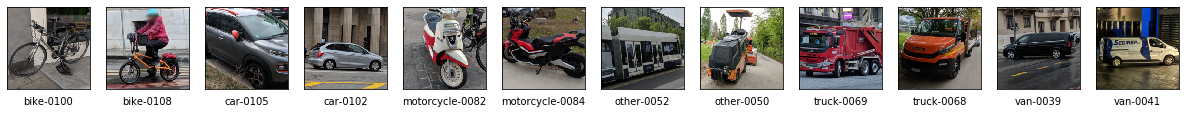

,bike,car,motorcycle,other,truck,van
bike-0100,99.99%,0.00%,0.00%,0.00%,0.00%,0.00%
bike-0108,99.75%,0.00%,0.23%,0.01%,0.00%,0.01%
car-0105,0.01%,99.26%,0.01%,0.01%,0.01%,0.71%
car-0102,0.00%,99.99%,0.00%,0.00%,0.00%,0.01%
motorcycle-0082,0.15%,0.01%,99.81%,0.01%,0.01%,0.01%
motorcycle-0084,0.01%,0.01%,99.97%,0.00%,0.00%,0.00%
other-0052,0.03%,0.00%,0.05%,98.63%,0.93%,0.36%
other-0050,0.03%,0.16%,0.36%,79.24%,20.14%,0.08%
truck-0069,0.00%,0.03%,0.00%,0.26%,99.70%,0.00%
truck-0068,0.00%,0.06%,0.02%,0.61%,98.84%,0.48%


In [23]:
CELL_WIDTH = 1.75
CELL_HEIGHT = 1.75

nrows = 1
ncols = len(label_strs) * NSAMPLES

# Get the corresponding images, high-level features and names.
X_sample = X_test[idxs_sample]
F_sample = F_test[idxs_sample]  # shape=(1280,)
F_sample = F_sample[np.newaxis, :]  # shape=(1, 1280)
N_sample = N_test[idxs_sample]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(ncols * CELL_WIDTH, nrows * CELL_HEIGHT),
                        sharex=True, sharey=True)

# Display the images.
for j, (ax, idx) in enumerate(zip(axs, idxs_sample)):
    ax.imshow(X_test[idx])
    
    # Add labels.
    name_short = pathlib.Path(N_test[idx]).stem
    ax.set_xlabel(f'{name_short}', fontsize=10)

    # X/y-axis: hide the ticks and their labels.
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

# Compute the probabilities.
F_sample = F_test[idxs_sample]  # shape=(1280,)
probas_sample = logreg_pipe.predict_proba(F_sample)

# The returned estimates for all classes are ordered by the label of classes.
short_names = [pathlib.Path(N_test[idx]).stem for idx in idxs_sample]
df = pd.DataFrame(data=probas_sample, index=short_names, columns=label_strs)

# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
df.style.highlight_max(axis=1).format('{:.2%}')

## Step 4: Vary the regularization strength of your estimator<a name="step-5.4"></a> ([top](#top-5))
--- 

We will modify the best parameters so far.

In [24]:
params_best

{'logreg': LogisticRegression(C=0.46415888336127775, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=200,
           multi_class='multinomial', n_jobs=None, penalty='l2',
           random_state=0, solver='saga', tol=0.0001, verbose=0,
           warm_start=False),
 'logreg__C': 0.46415888336127775,
 'logreg__max_iter': 200,
 'logreg__multi_class': 'multinomial',
 'logreg__solver': 'saga',
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [25]:
# Cs is defined above.
C_min = Cs.min()
C_max = Cs.max()
print(f'C_min: {C_min}, C_max: {C_max}')

C_min: 0.0001, C_max: 10000.0


We define a helper function to retrain with different values of _C_.

In [26]:
def train_for_C(logreg_pipe, params, C, F_train, y_train, F_test, y_test, F_sample):
    # Compute the probabilities.
    params_C = params.copy()
    params_C['logreg__C'] = C
    params_C['logreg__max_iter'] = 1000
    
    with warnings.catch_warnings():

        # Filter convergence warnings.
        warnings.simplefilter('ignore', ConvergenceWarning)
        
        logreg_pipe.set_params(**params_C)
        logreg_pipe.fit(F_train, y_train)

        accuracy_train = logreg_pipe.score(F_train, y_train)
        accuracy_test = logreg_pipe.score(F_test, y_test)
        print(f'C={C}')
        print(f'training accuracy: {accuracy_train:.2%}')
        print(f'test accuracy: {accuracy_test:.2%}')

        probas_sample = logreg_pipe.predict_proba(F_sample)
        # The returned estimates for all classes are ordered by the label of classes.
        short_names = [pathlib.Path(N_test[idx]).stem for idx in idxs_sample]
        df = pd.DataFrame(data=probas_sample, index=short_names, columns=label_strs)

        # https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
        return df.style.highlight_max(axis=1).format('{:.2%}')

Here are the results for `C_min` (strong regularization).

In [27]:
train_for_C(logreg_pipe, params_best, C_min, F_train, y_train, F_test, y_test, F_sample)

C=0.0001
training accuracy: 82.86%
test accuracy: 88.00%


,bike,car,motorcycle,other,truck,van
bike-0100,55.76%,10.37%,12.38%,7.48%,7.96%,6.04%
bike-0108,47.26%,10.75%,18.97%,8.17%,8.48%,6.36%
car-0105,14.17%,43.79%,10.86%,8.66%,11.56%,10.96%
car-0102,8.96%,58.29%,7.65%,6.97%,9.00%,9.14%
motorcycle-0082,21.86%,12.48%,38.47%,10.58%,9.69%,6.92%
motorcycle-0084,18.77%,13.99%,41.53%,9.10%,9.70%,6.91%
other-0052,18.83%,16.99%,14.17%,18.42%,18.56%,13.03%
other-0050,13.92%,14.96%,18.25%,22.71%,21.32%,8.84%
truck-0069,15.54%,17.54%,13.24%,16.84%,26.90%,9.94%
truck-0068,12.77%,19.90%,13.60%,14.18%,26.42%,13.14%


Here are the results for `C_max` (weak regularization).

In [28]:
train_for_C(logreg_pipe, params_best, C_max, F_train, y_train, F_test, y_test, F_sample)

C=10000.0
training accuracy: 100.00%
test accuracy: 90.00%


,bike,car,motorcycle,other,truck,van
bike-0100,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%
bike-0108,99.94%,0.00%,0.06%,0.00%,0.00%,0.00%
car-0105,0.00%,99.65%,0.00%,0.00%,0.00%,0.34%
car-0102,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%
motorcycle-0082,0.03%,0.00%,99.97%,0.00%,0.00%,0.00%
motorcycle-0084,0.00%,0.00%,99.99%,0.00%,0.00%,0.00%
other-0052,0.11%,0.00%,0.10%,54.28%,7.04%,38.46%
other-0050,0.01%,0.00%,0.10%,73.10%,26.78%,0.01%
truck-0069,0.00%,0.01%,0.00%,1.78%,98.20%,0.00%
truck-0068,0.00%,0.02%,0.01%,0.22%,98.95%,0.79%


**Comment:** We observe that with a strong regularization, the probabilities are more disributed among classes (in particular, the probability for the actual class is lower). With a weak regularization, the probabilities are more concentrated on one class in particular.